# Шифрование данных: очень простое преобразование данных с целью шифрования с обоснованием метода

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Оглавление<a class='anchor' id='TOC'>
***

* **[1. Загрузка и исследование данных](#1)**
    - [1) Загрузим необходимые библиотеки](#1_1)
    - [2) Прочитаем даннные](#1_2)
    - [3) Выведем пять первых, последних и случайных строк](#1_3)
    - [4) Выведем общую информацию о датасете, общую статистику, проверим дубликаты, уникальные значения и корреляцию](#1_4)
    - [5) Визуализируем данные, проверим отдельные столбцы и построим диаграмму пар признаков](#1_5)
    - [Вывод](#1_conclusion)
* **[2. Умножение матриц](#2)**
* **[3. Алгоритм преобразования](#3)**
* **[4. Проверка алгоритма](#4)**

## 1. Загрузка и исследование данных<a class='anchor' id='1'>
***

### 1) Загрузим необходимые библиотеки<a class='anchor' id='1_1'>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

In [2]:
class Display(object):
    """
    Выводит HTML представление нескольких объектов
       
    Пример:
    Display(head, tail, sample)
    """
    template = """<div style="float: left; padding: 10px;">
        <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
        </div>"""
    
    def __init__(self, *args):
            self.args = args

    def _repr_html_(self):
            return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                             for a in self.args)

    def __repr__(self):
            return '\n\n'.join(a + '\n' + repr(eval(a))
                               for a in self.args)

In [3]:
np.random.seed(42)

[В оглавление](#TOC)

### 2) Прочитаем даннные<a class='anchor' id='1_2'>

In [4]:
df = pd.read_csv('insurance.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

[В оглавление](#TOC)

### 3) Выведем пять первых, последних и случайных строк<a class='anchor' id='1_3'>

In [5]:
df.head(5)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [6]:
df.tail(5)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0
4999,1,28.0,40600.0,1,0


In [7]:
df.sample(5)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
1501,1,28.0,56100.0,0,0
2586,1,32.0,41900.0,2,0
2653,1,30.0,26300.0,0,0
1055,1,30.0,37300.0,2,0
705,0,44.0,30000.0,1,1


&#9889; **Вывод:**
на основании первого визуального ознакомления с данными - ничего необычного. С некоторой осторожностью можно предположить, что целевой положительный признак (> 0) - редкий.

[В оглавление](#TOC)

### 4) Выведем общую информацию о датасете, общую статистику, проверим дубликаты, уникальные значения и корреляцию<a class='anchor' id='1_4'>

#### - общая информация о датасете

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


В датасете 5000 строк, пропущенных нет, проблем с типами данных нет.

#### - общая статистика

In [9]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Странных значений не усматривается.

#### - проверим наличие полных дубликатов

In [10]:
df.duplicated().sum()

153

В датасете 153 полных дубликата, что составляет 3 % от выборки (153 / 5000). Кандидаты на удаление, но прежде проверим уникальные значения.

#### - уникальные значения

In [11]:
df.nunique()

Пол                    2
Возраст               46
Зарплата             524
Члены семьи            7
Страховые выплаты      6
dtype: int64

1. Уникальных значений сравнительно немного, даже в заработной плате всего 524 отличных наблюдения. 
2. В совокупности с уже полученными результатами анализа - с осторожностью предположу, что в датасете представлены данные о сотрудниках одной организации (возможно даже, что самой страховой компании "ХотьПотоп"; дополнительно данный вывод подтвержает и порядок зарплат, характерный для страховых компаний).
3. Принимая во внимание полученные результаты анализа можно предположить, что в датасете данные о добровольном медицинском страховании.
4. Полные дубликаты будут сохранены - в совокупностью с размером выборки и количеством уникальных значений, отсутствие дополнительных идентифицирующих признаков - не столь уж маловероятно получить полный дубликат.

#### - проверим корреляцию

In [12]:
df.corr()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.002074,0.014910,-0.008991,0.010140
Возраст,0.002074,1.000000,-0.019093,-0.006692,0.651030
Зарплата,0.014910,-0.019093,1.000000,-0.030296,-0.014963
Члены семьи,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
Страховые выплаты,0.010140,0.651030,-0.014963,-0.036290,1.000000


&#9889; **Вывод:**
1. В датасете наблюдается относительно сильная линейная положительная корреляция между страховым случаем и возрастом(0.65). Линейная корреляция с остальными признаками стремится к нулю.
2. С осторожностью можно утверждать, что корреляция между страховым случаем и другими признаками носит нелинейный характер.

[В оглавление](#TOC)

### 5) Визуализируем данные, проверим отдельные столбцы и построим диаграмму пар признаков<a class='anchor' id='1_5'>

#### - пол

In [13]:
df['Пол'].value_counts()

0    2505
1    2495
Name: Пол, dtype: int64

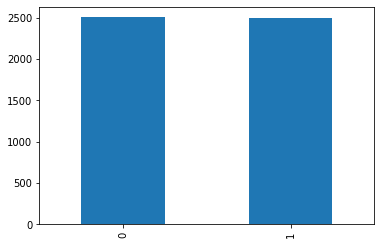

In [14]:
df['Пол'].value_counts().plot.bar()

&#9889; **Вывод:**
в представленном датасете примерно поровну мужчин и женщин, но установить кого больше не представляется возможным: наблюдений с плейсхолдером 0 - 2 505 из 5000, наблюдений с плейсхолдером 1 - 2 495 из 5 000.

#### - возраст

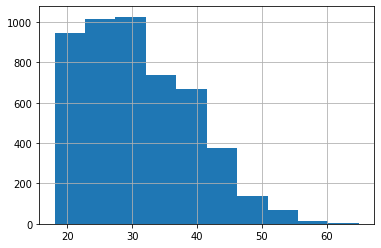

In [15]:
df['Возраст'].hist()

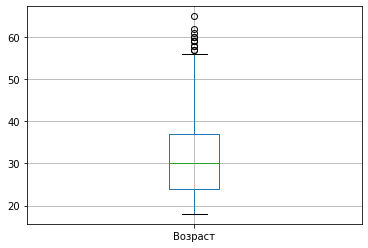

In [16]:
df.boxplot('Возраст')

&#9889; **Вывод:**
1. Распределение скошено вправо.
2. Есть несущественные и немногочисленные выбросы, которые будут сохранены: возраст клиента, исходя из исследования, часть сути явления, влияет на число страховых выплат.
3. Медиана и среднее совпадают.

#### - зарплата

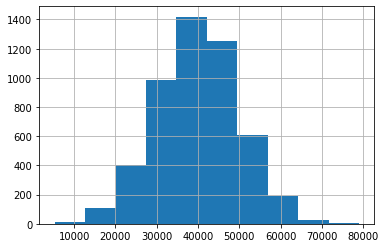

In [17]:
df['Зарплата'].hist()

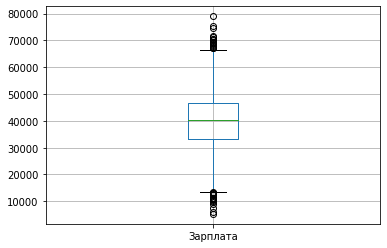

In [18]:
df.boxplot('Зарплата')

&#9889; **Вывод:**
1. Распределение в форме колокола, есть хвосты.
2. В данных есть выбросы: судя по положению медианы, выбросы оказывают незначительное влияние и потому будут сохранены.

#### - члены семьи

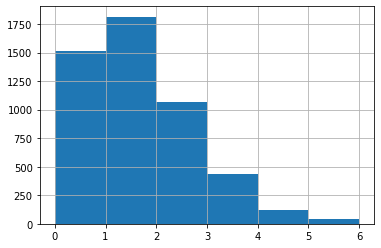

In [19]:
df['Члены семьи'].hist(bins=6)

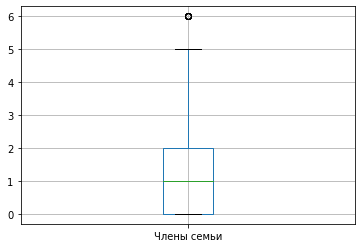

In [20]:
df.boxplot('Члены семьи')

&#9889; **Вывод:**
1. Распределение скошено вправо.
2. Выбросов практически нет - в данной выборке таковыми являются малочисленные наблюдения с шестью детьми, которые не влияют на среднее, совпадающее с медианой.

#### - страховые выплаты

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

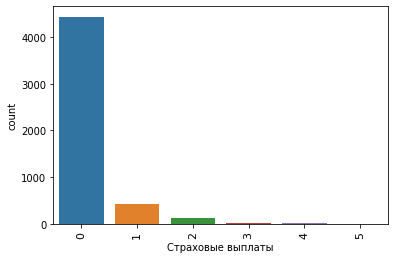

In [21]:
ax = sns.countplot(df['Страховые выплаты'], order = df['Страховые выплаты'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)   
plt.xticks(rotation=90)

In [22]:
(df['Страховые выплаты'] > 0).sum()

564

&#9889; **Вывод:** в представленной выборке количество страховых случав стремится к нулю: всего 564 из 5000 (11%).

#### - построим диаграммы для пар признаков: пола, возраста, зарплаты, членов семьи и страхового случая

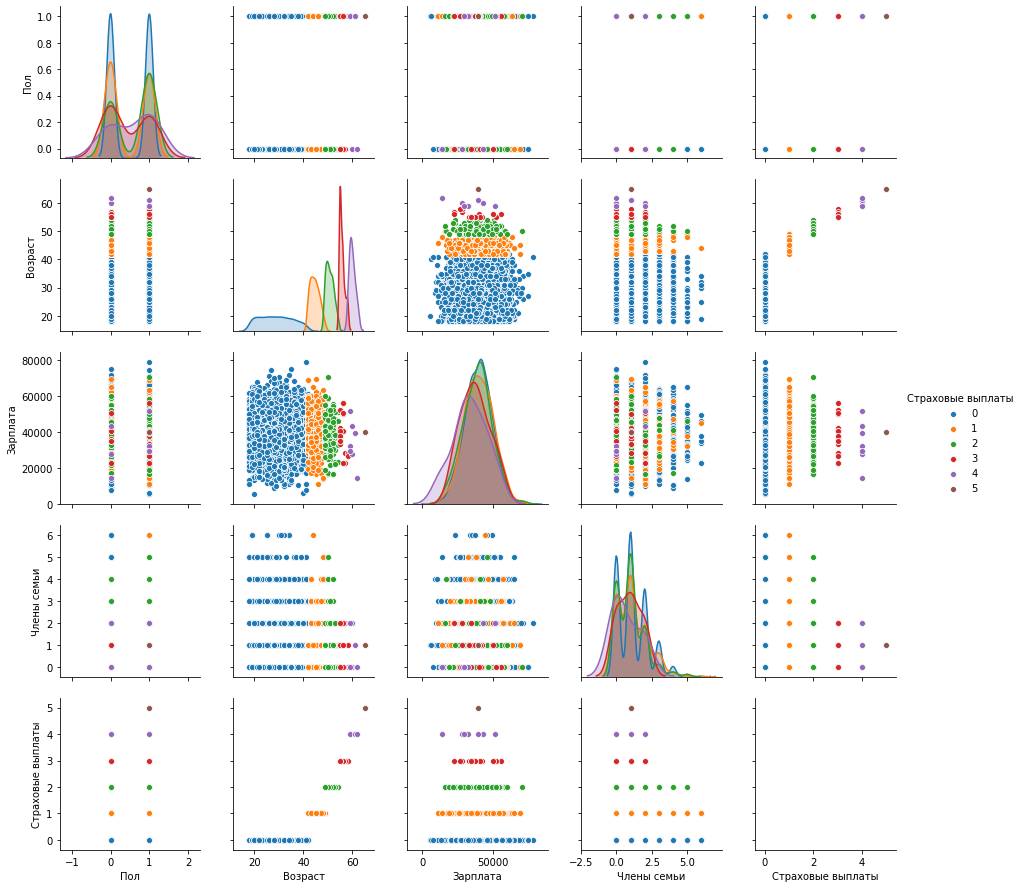

In [23]:
sns.pairplot(df[['Пол', 'Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты']], hue='Страховые выплаты')

&#9889; **Вывод:**
к уже установленной линейной зависимости между страховыми случаями и возрастом на основе диаграммы пар признаков можно добавить следующее:
- усматривается положительная зависимость между количеством членов семьи и страховыми случаями.
- чем ближе заработная плата к среднему значению в 40 000 рублей - тем больше страховых случаев.

[В оглавление](#TOC)

### Вывод:<a class='anchor' id='1_conclusion'>

1. В датасете 5000 строк, пропущенных данных нет, проблем с типами данных нет.
2. Странных значений не усматривается. Есть немногочисленные выбросы, которые будет сохранены и как часть исследуемого явления, так и  силу незначительности влияния на среднее.
3. В датасете 153 полных дубликата (3 % от выборки из 5000 наблюдений), которые будут сохранены в силу малой вариативности признаков.
4. В представленном датасете примерно поровну мужчин и женщин, но установить пол в каждом из наблюдений не представляется возможным: значений с плейсхолдером 0 - 2 505 из 5000, наблюдений с плейсхолдером 1 - 2 495 из 5 000.
5. В датасете наблюдается относительно сильная линейная положительная корреляция между страховым случаем и возрастом (0.65). Усматривается нелинейная корреляция между страховыми выплатами, количеством членов семьи и заработной плате: чем больше членов семьи, тем больше страховых случаев; чем ближе заработная плата к среднему значению (40 000 рублей) - тем больше страховых случаев.
6. В представленной выборке количество страховых случав стремится к нулю – 564 из 5000 (11%).
7. Принимая во внимание полученные результаты анализа, исходя из представленных данных, с осторожностью можно предположить, что в датасете собраны данные о добровольном медицинском страховании в рамках одной организации (возможно, что о сотрудниках компании «ХотьПотоп»).
8. Необходимо отметить, что данные не отвечают критериям персональных - идентификация клиента по данным значениям невозможна.

[В оглавление](#TOC)

## 2. Умножение матриц<a class='anchor' id='2'>
***

**Вопрос:** признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

**Ответ:** не изменится.

**Обоснование:** 

1. Введем обозначения:

    - $X_{m,n}$ — матрица признаков (нулевой столбец состоит из единиц)
    
    - $A_{n,n}$ — матрица на которую умножают признаки и для которой существует обратная матрица.

    - $y$ — вектор целевого признака

    - $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)
    
    - $\alpha$ — вектор предсказаний модели.
    
    
2. Вектор предсказаний модели - является произведением признаков на вектор весов линейной регресии:

$$
\alpha = Xw
$$

3. Задача обучения - определение вектора весов линейной регрессии по обучающей выборке, при котором достигается минимум среднего квадрата ошибки (метод наименьших квадратов):

$$
w = \arg\min_w MSE(Xw, y)
$$

4. Обратная для квадратной матрицы — матрица, произведение которой на обратимую равно единичной матрице. Свойство обратимости для матриц является существенным условием для решения системы линейных уравнений, поскольку делить матрицы нельзя - вместо деления умножают на обратную матрицу.


5. Формула обучения для определения вектора весов линейной регрессии $w$ по обучающей выборке имеет вид:

$$
w = (X^T X)^{-1} X^T y
$$

6. Тогда для матрицы признаков $X$ вектор предсказаний модели: 

$$
a = X(X^TX)^{-1}X^Ty
$$

7. Если $X$ матрица признаков, а $A$ — матрица на которую умножают признаки и для которой существует обратная матрица, тогда $XS$ - результат умножения матрицы признаков на обратимую матрицу.


8. Следовательно, для матрицы $XA$ вектор весов:

$$
w` = ((XA)^TXA)^{-1}(XA)^Ty = (A^TX^TXA)^{-1}A^TX^Ty
$$


9. Как следствие,

$$
A^TX^TXAw` = A^TX^Ty
$$

$$
=> X^TXAw` = X^Ty
$$

$$
=> Aw` = (X^TX)^{-1}X^Ty = w
$$

$$
=> w` = A^{-1}w
$$

10. Тогда вектор предсказаний модели $a`$ для матрицы $XA$ примет вид:

$$
a` = XAw` = XAA^{-1}w = Xw = a
$$


10. Следовательно, перемножение матрицы признаков на обратимую матрицу $А$ не влияет на результат линейной регрессии, качество не измениться, коэффициент $R^2$ останется неизменным. Признаки в преобразованной задаче - скалированые признаки в изначальной задаче. Скалирование признаков не влияет на модель - когда переменная увеличивается на определенное значение, соответствующий коэффициент уменьшается на пропорциональное значение.

[В оглавление](#TOC)

## 3. Алгоритм преобразования<a class='anchor' id='3'>
***

**Алгоритм**

1. К матрице признаков $P_{m,n}$ прибавляют единицу, чтобы избавиться от нулевых значений.

$$
P_{m,n} + 1
$$

2. Генерируются случайная обратимая матрица-ключ $K$ размером равная $n$.


3. К матрице признаков $P_{m,n} + 1$ прибавляется матрица признаков $P_{m,n} + 1$ со сдвигом столбцов влево.

$$
F_{m,n} = (P_{m,n} + 1) + (P_{m,n, -1} + 1)
$$


4. Полученная матрица $F_{m,n}$ умножается на матрицу-ключ $K$:

$$
F_{m,n}K
$$

**Обоснование**

1. Прибавление единицы для избавления от возможных нулей в матрице признаков обеспечивает правильное скалирование и дешифровку.

2. За счет сдвига по горизонтали признаки перемешиваются между собой, каждый из элементов строки матрицы признаков состоит из собственного значения (с поправкой на единицу) и значения соседнего по горизонтали элемента.

3. Поскольку матрица признаков умножается на обратимую матрицу получаем зашифрованный анонимизированный датасет. При этом даже бинарные признаки в изначальных данных не подлежат считыванию после шифрования.

4. Как следствие, даже значние ключа само по себе не обеспечивает деанонимизацию данных.

5. Поскольку в результате работы алгоритма признаки равномерно скалированы - алгоритм не повлияет на качество линейной регрессии.

6. Цена работы алгортима - незначительный шум в зашифрованных данных, который не влияет на качество.

[В оглавление](#TOC)

## 4. Проверка алгоритма<a class='anchor' id='4'>
***

### 1) Объявим класс DataEncryptorPrototype, который зашифрует данные, подготовит модели, соберет результат проверки алгоритма

In [24]:
class DataEncryptorPrototype:
    
    def __init__(self, features, target):
        self.model = LinearRegression()
        self.features = features
        self.target = target
        self.key = np.random.rand(features.shape[1], features.shape[1])
        
    def encryptor(self):
        return ((self.features+1) + np.roll((self.features+1), -1)).dot(self.key)
    
    def decryptor(self):
        features_decrypted = (self.encryptor().dot(np.linalg.inv(self.key)) - 1 - np.roll(self.features, -1))
        return pd.DataFrame(np.round(features_decrypted)-1)
    
    def reporter(self):
        report = []
        features_data = [('Без шифрования', self.features), ('C шифрованием', self.encryptor())]

        for i in range(len(features_data)):
            x_train, x_test, y_train, y_test = train_test_split(features_data[i][1], self.target, test_size=0.2, random_state=42)
            model = self.model.fit(x_train, y_train)
            model_score = model.score(x_test, y_test)

            report.append((features_data[i][0], model_score))

        final_report = pd.DataFrame(report, columns=['Model', 'r2_score'])

        return final_report

#### - инициализируем DataEncryptorPrototype:

In [25]:
DataEncryptor = DataEncryptorPrototype(df.drop('Страховые выплаты', axis=1).values, df['Страховые выплаты'])

#### - выведем $R^2$ после работы алгоритма

In [26]:
DataEncryptor.reporter()

,Model,r2_score
0,Без шифрования,0.436869
1,C шифрованием,0.436904


#### - выведем на экран зашифрованные данные, расшифрованные, изначальный датасет

In [27]:
encrypted = pd.DataFrame(DataEncryptor.encryptor())
decrypted = DataEncryptor.decryptor()
original = df.drop('Страховые выплаты', axis=1)
Display('encrypted', 'decrypted', 'original')

,0,1,2,3
0,56473.508866,45775.894985,58320.975800,78658.879342
1,43272.977231,35079.731987,44702.833612,60285.554098
2,23916.315468,19389.060610,24710.777890,33322.751027
3,47475.606774,38477.638896,49013.902315,66112.596368
4,29721.032612,24092.535981,30700.373372,41403.243496
...,...,...,...,...
4995,40649.230241,32947.783124,41976.336371,56615.632148
4996,59657.217230,48354.113234,61599.152957,83084.399219
4997,38597.730438,31282.759195,39851.042150,53752.072565
4998,37234.346036,30177.681699,38445.609812,51855.474910


[В оглавление](#TOC)